<a href="https://colab.research.google.com/github/thvls/img-segment/blob/main/how_to_segment_images_with_sam_2_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Images with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

Segment Anything Model 2 (SAM 2) is a foundation model designed to address promptable visual segmentation in both images and videos. The model extends its functionality to video by treating images as single-frame videos. Its design, a simple transformer architecture with streaming memory, enables real-time video processing. A model-in-the-loop data engine, which enhances the model and data through user interaction, was built to collect the SA-V dataset, the largest video segmentation dataset to date. SAM 2, trained on this extensive dataset, delivers robust performance across diverse tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Complementary materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model 2 (SAM2).

[![SAM2 blogpost](https://media.roboflow.com/notebooks/examples/blog-what-is-sam-2.png)](https://blog.roboflow.com/what-is-segment-anything-2)

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Nov 30 12:56:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -v

Streaming output truncated to the last 5000 lines.
    Found link https://files.pythonhosted.org/packages/e5/53/92a8ac9d252ec170d9197dcf988f07e02305a06078d7e83a41ba4e3ed65b/setuptools-33.1.1-py2.py3-none-any.whl (from https://pypi.org/simple/setuptools/) (requires-python:>=2.6,!=3.0.*,!=3.1.*,!=3.2.*), version: 33.1.1
    Found link https://files.pythonhosted.org/packages/dc/8c/7c9869454bdc53e72fb87ace63eac39336879eef6f2bf96e946edbf03e90/setuptools-33.1.1.zip (from https://pypi.org/simple/setuptools/) (requires-python:>=2.6,!=3.0.*,!=3.1.*,!=3.2.*), version: 33.1.1
    Found link https://files.pythonhosted.org/packages/67/d9/0633db28d5c86047501909cdb7c2614602ca425c14ff38faf9eafa383010/setuptools-34.0.0-py2.py3-none-any.whl (from https://pypi.org/simple/setuptools/) (requires-python:>=2.6,!=3.0.*,!=3.1.*,!=3.2.*), version: 34.0.0
    Found link https://files.pythonhosted.org/packages/4f/5d/77ab299135d7a882fff2970b45c6a77d7d79db0363c395081770632e6f1d/setuptools-34.0.0.zip (from https://p

In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data




In [7]:
# !wget https://i0.wp.com/trove42.com/wp-content/uploads/2022/09/Thank-you-Federer.jpg?fit=750%2C511&ssl=1 -P {HOME}/data

!wget  https://static.independent.co.uk/s3fs-public/thumbnails/image/2014/01/22/10/federer-1.jpg?width=1200 -P {HOME}/data
!mv /content/data/federer-1.jpg?width=1200 /content/data/federer.jpg

--2024-11-30 13:01:13--  https://static.independent.co.uk/s3fs-public/thumbnails/image/2014/01/22/10/federer-1.jpg?width=1200
Resolving static.independent.co.uk (static.independent.co.uk)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to static.independent.co.uk (static.independent.co.uk)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102222 (100K) [image/jpeg]
Saving to: ‘/content/data/federer-1.jpg?width=1200’

federer-1.jpg?width 100%[===================>]  99.83K  --.-KB/s    in 0.02s   

2024-11-30 13:01:14 (5.06 MB/s) - ‘/content/data/federer-1.jpg?width=1200’ saved [102222/102222]



### Imports

In [8]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [9]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [31]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [32]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

**NOTE:** OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

In [33]:
IMAGE_PATH = f"{HOME}/data/federer.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam2_result = mask_generator.generate(image_rgb)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

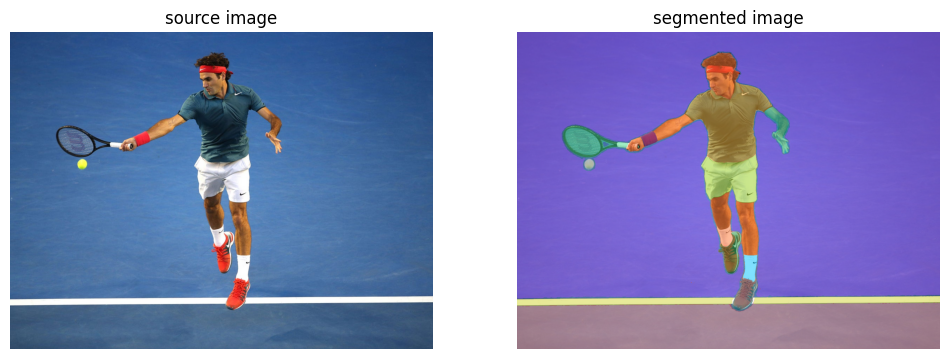

In [13]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

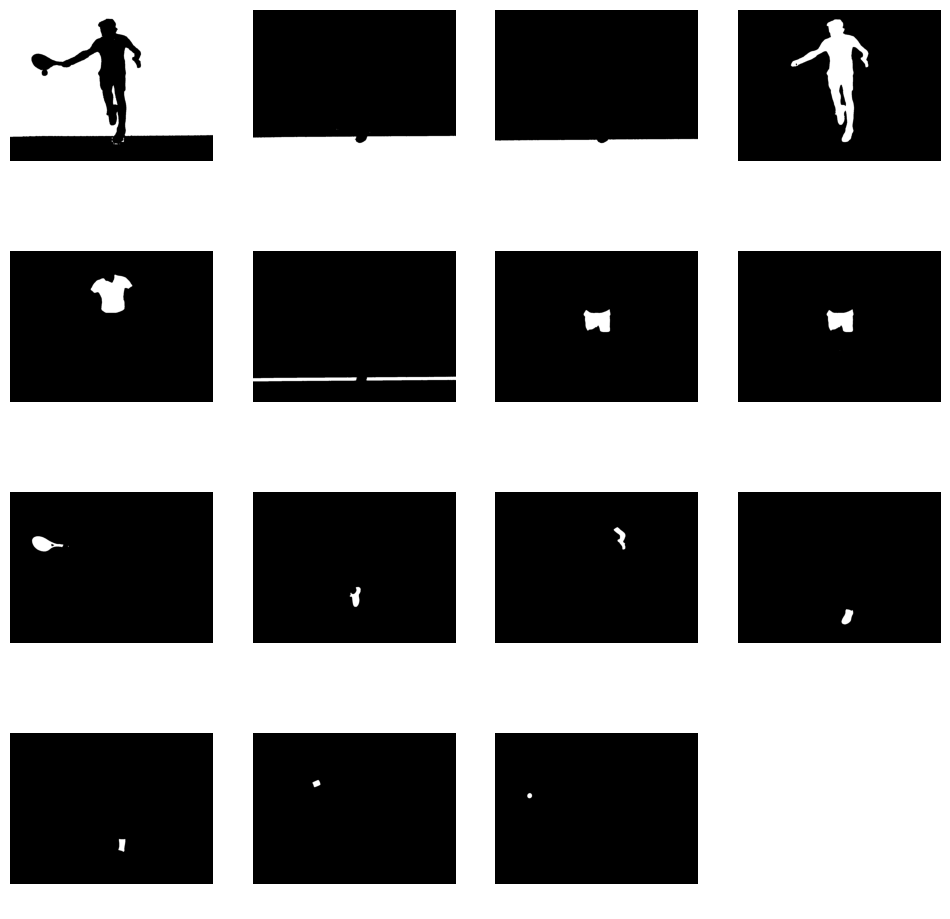

In [14]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

def get_dominant_color(image, mask, num_colors=5, plot_colors=False):
    """
    Get the dominant color for a segmentation mask of an input image.

    Parameters:
    - image: Input image (numpy array).
    - mask: Segmentation mask (numpy array).
    - num_colors: Number of color clusters to group similar colors.
    - plot_colors: Boolean flag to plot the different colors found per segment.

    Returns:
    - dominant_color: The most dominant color in the masked region.
    """
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply the mask to the image
    mask = mask.astype(np.uint8)
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    # Reshape the image to be a list of pixels
    pixels = masked_image.reshape(-1, 3)

    # Remove black pixels (background)
    pixels = pixels[np.all(pixels != [0, 0, 0], axis=1)]

    # Use K-means clustering to find the most dominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Count the number of pixels in each cluster
    label_counts = Counter(labels)

    # Find the most common color
    dominant_color = colors[label_counts.most_common(1)[0][0]]

    if plot_colors:
        # Plot the colors
        plt.figure(figsize=(8, 6))
        plt.pie(label_counts.values(), labels=[f'Color {i}' for i in range(num_colors)], colors=[colors[i]/255 for i in range(num_colors)])
        plt.show()

        # Plot masked image
        plt.figure(figsize=(8, 6))
        plt.imshow(masked_image)
        plt.axis('off')
        plt.show()

    return dominant_color.astype(int)

# Example usage
image = cv2.imread(IMAGE_PATH)
mask = sam2_result[0]['segmentation']
dominant_color = get_dominant_color(image, mask, num_colors=5, plot_colors=True)
print(f"The most dominant color is: {dominant_color}")

In [ ]:
# For each mask, get the most dominant color
dominant_colors = [get_dominant_color(image, mask, num_colors=5) for mask in masks]

# Plot the dominant colors
sv.plot_images_grid(
    images=dominant_colors[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

# Fill the segmentation masks with its dominant color and plot them on one image
dominant_color_masks = [np.full_like(image, color) for color in dominant_colors]
dominant_color_image = np.zeros_like(image)

for mask, color in zip(masks, dominant_color_masks):
    dominant_color_image += cv2.bitwise_and(color, color, mask=mask)

plt.figure(figsize=(8, 6))
plt.imshow(dominant_color_image)
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def smoothen_masks(masks, kernel_size=5, blur_size=5, threshold_value=50, debug_plot=True):
    """
    Smoothen the borders of all segmentation masks.

    Parameters:
    - masks: List of segmentation masks (numpy arrays).
    - kernel_size: Size of the kernel for morphological operations.
    - blur_size: Size of the kernel for Gaussian blur.
    - threshold_value: Threshold value for binarizing the mask.

    Returns:
    - smoothened_masks: List of smoothened segmentation masks.
    """
    smoothened_masks = []
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    for mask in masks:
        # Apply closing operation (dilation followed by erosion)
        closed_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        
        if debug_plot:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(mask, cmap='gray')
            axes[0].set_title('Original Mask')
            axes[0].axis('off')
            
            axes[1].imshow(closed_mask, cmap='gray')
            axes[1].set_title('Closed Mask')
            axes[1].axis('off')
            plt.show()

        # Apply Gaussian blur to smoothen the edges
        smoothened_mask = cv2.GaussianBlur(closed_mask, (blur_size, blur_size), 0)
        
        if debug_plot:
            plt.figure(figsize=(6, 6))
            plt.imshow(smoothened_mask, cmap='gray')
            plt.title('Smoothened Mask')
            plt.axis('off')
            plt.show()

        # Threshold to get binary mask
        _, smoothened_mask = cv2.threshold(smoothened_mask, threshold_value, 255, cv2.THRESH_BINARY)

        if debug_plot:
            plt.figure(figsize=(6, 6))
            plt.imshow(smoothened_mask, cmap='gray')
            plt.title('Binary Mask')
            plt.axis('off')
            plt.show()
        
        smoothened_masks.append(smoothened_mask)

    return smoothened_masks

# Example usage
smoothened_masks = smoothen_masks(masks, kernel_size=5, blur_size=5, threshold_value=50)

# Plot the original and smoothened masks for comparison
fig, axes = plt.subplots(2, len(masks), figsize=(20, 10))
for i, (original, smoothened) in enumerate(zip(masks, smoothened_masks)):
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].set_title('Original Mask')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(smoothened, cmap='gray')
    axes[1, i].set_title('Smoothened Mask')
    axes[1, i].axis('off')

plt.show()

# Plot the masks in a grid with 4 masks per line
def plot_masks_grid(masks, grid_size=(4, 4), size=(12, 12)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=size)
    for i, mask in enumerate(masks):
        row = i // grid_size[1]
        col = i % grid_size[1]
        axes[row, col].imshow(mask, cmap='gray')
        axes[row, col].axis('off')
    plt.show()

# Example usage
plot_masks_grid(smoothened_masks, grid_size=(4, 4), size=(12, 12))

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [15]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [16]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

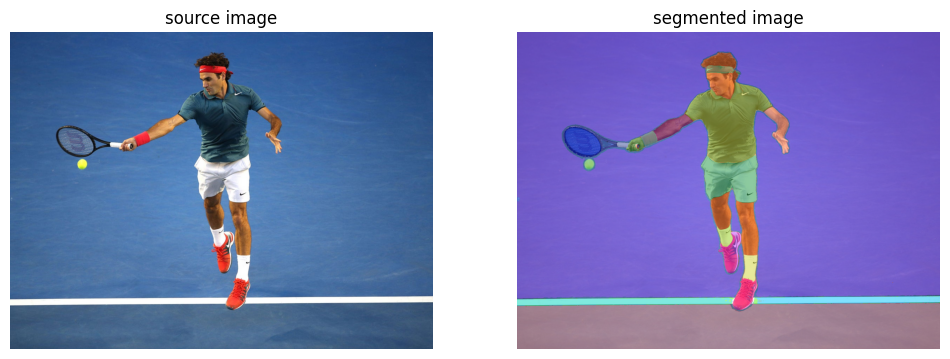

In [17]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with boxes

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [18]:
predictor = SAM2ImagePredictor(sam2_model)

In [19]:
IMAGE_PATH = f"{HOME}/data/federer.jpg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Interactive box prompt

In [20]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [34]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [35]:
widget.bboxes

[{'x': 511, 'y': 342, 'width': 178, 'height': 143, 'label': ''}]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [36]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [37]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)


### Results visualisation

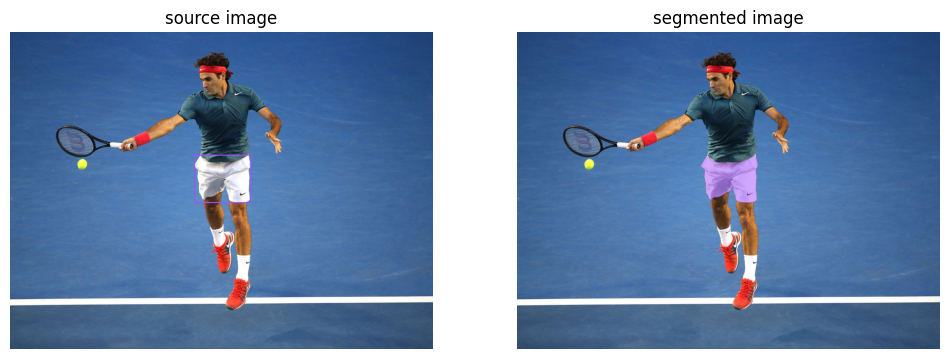

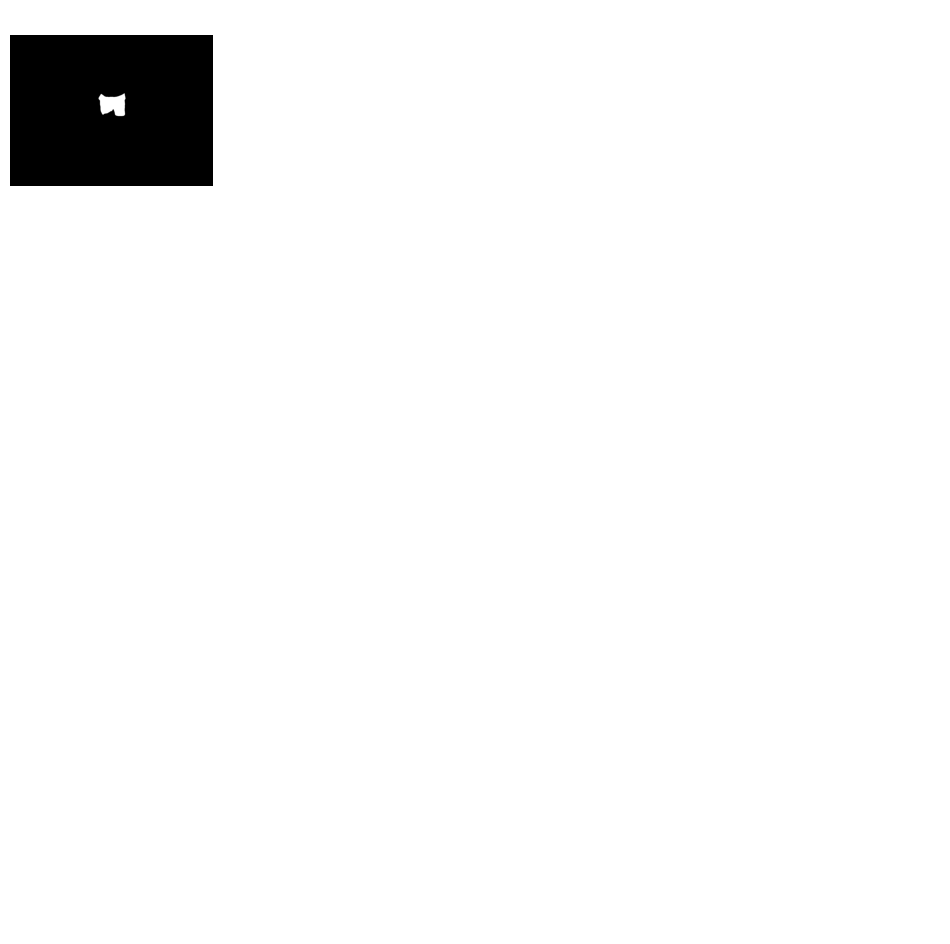

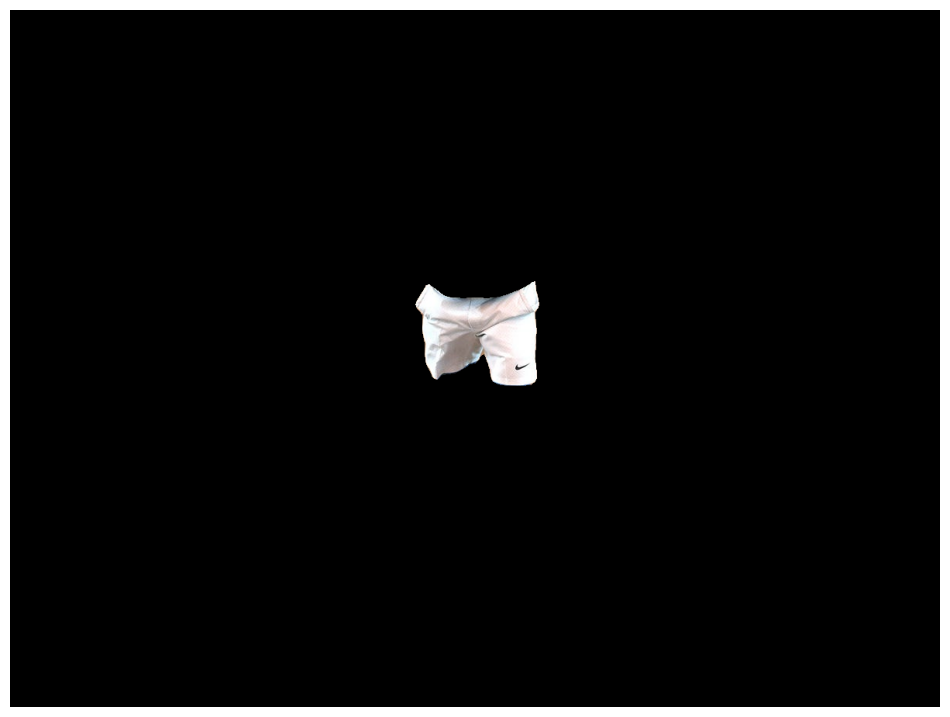

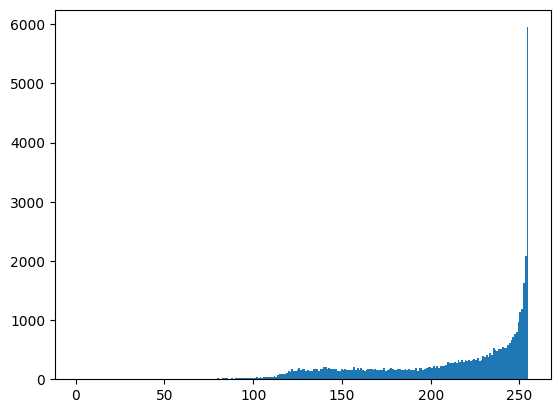

The most dominant color is: (255, 255, 253)


In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Plot each mask in white on black background
sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

np.histogram(masks[0], bins=32, range=(0, 1))

import matplotlib.pyplot as plt

# Extract mask portion from original image
image_mask = image_rgb.copy()
image_mask[masks[0] == 0] = 0

sv.plot_image(image_mask)

plt.hist(image_mask.flatten(), range=(1,255), bins=255) # This must be split per color channel
plt.show()

# Example usage
image_path = IMAGE_PATH
dominant_color = get_dominant_color(image_path)

if dominant_color:
    print(f"The most dominant color is: {dominant_color}")
else:
    print("No dominant color found, or only black and white colors are present.")



In [ ]:
# Select the most dominant color and draw it on the mask
image_mask = image_rgb.copy()

# Define the color to draw
color = dominant_color

# Draw the mask on top of the original image
image_mask[masks[0] == 0] = color

sv.plot_image(image_mask)



## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [26]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [27]:
widget.bboxes

[]

In [28]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [29]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

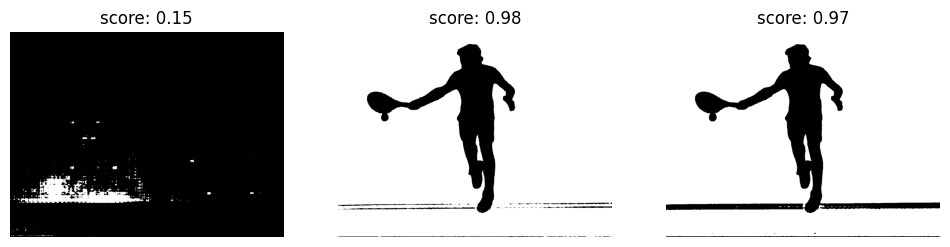

In [30]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)